Neste trabalho vamos utilizar o dataset Breast Cancer Wisconsin

1. ID do paciente 
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
3. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de nucleos normais (1-10)
10. Mitoses (1-10)
11. [SAIDA] Classificação (2 para indicar BENIGNO, 4 Para indicar MALIGNO)

O dataset contém 458 amostras com: 
- 65.5% de casos BENIGNO
- 34.5% de casos MALIGNO

## 1.Preparação do ambiente

In [20]:
#importacao de bibliotecas
import subprocess
import sys
#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Model, load_model # pyright: ignore[reportMissingImports]
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout # pyright: ignore[reportMissingImports]

from tensorflow.keras.optimizers import Adam, Nadam # pyright: ignore[reportMissingImports]
from tensorflow.keras.utils import plot_model # pyright: ignore[reportMissingImports]
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # pyright: ignore[reportMissingImports]
from tensorflow.keras.metrics import BinaryCrossentropy # pyright: ignore[reportMissingImports]

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot # pyright: ignore[reportMissingImports]
tensorflow.keras.utils.pydot = pyd

In [21]:
#checagem de GPU
import tensorflow as tf
import keras
print('tensorflow: ', tf.__version__)
print('Keras: ', keras.__version__)
print('GPU disponivel: ', len(tf.config.list_physical_devices('GPU')) > 0)
print('GPU(s): ', tf.config.list_physical_devices('GPU'))

tensorflow:  2.13.1
Keras:  2.13.1
GPU disponivel:  False
GPU(s):  []


In [22]:
#rotina para exportacao da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
                                capture_output = True,
                                text = True,
                                check = True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f'Deu erro: {e}')
exportaRequirements()

Arquivo exportado com sucesso!


## 2.Importação do dataset

In [23]:
#2 benigno 4 maligno
#cria um nome para cada coluna do dataset
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus'
            ,'cromatina', 'nucleos_normais', 'mitoses', 'diagnostico']
#importacao do dataset
data = pd.read_csv('dataset/breast-cancer-wisconsin(in).csv', header=None, names=col_names)
#remove a coluna id pois e inutil
data = data.drop('ID', axis=1)
#substitui '?' por NaN
data = data.replace('?', np.nan)
#converte tudo para numero
data = data.astype(float)
#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagnostico'].replace({2:0,4:1}))
#nomeia as entradas esaidas
x_names = data.columns[:-1].to_list()
y_names = data.columns[-1:].to_list()
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do Experimento

In [24]:
#realizar interpolação de dados
interp_exec = True
#realizar detecção e substituição de outliers
outliers_exec = True
#realizar normalização de dados
normalization_exec = True
#realizar escalonamento de dados
scale_exec = True
#exportar os datasets tratados
export_frames = True
#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de dados

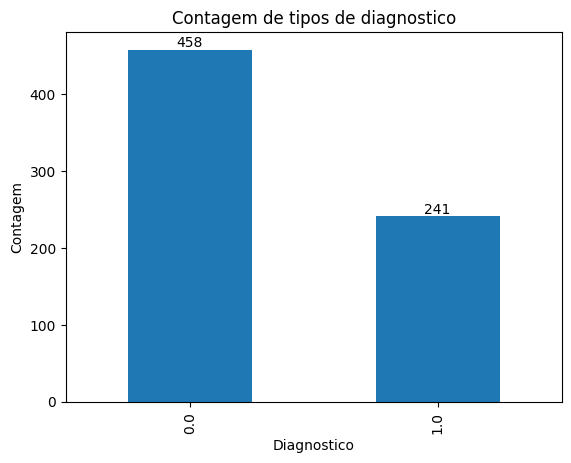

In [25]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()
#plotar grafico de barra
plt.Figure(figsize=(4,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnostico')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnostico')
#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i,count,str(count), ha='center',va='bottom')
plt.show()

### 4.1. Sumarização estatistica

In [26]:
def sumarizacao(data):
    stats = []
    for column in x_names:
        values = data[column]
        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)
        stats.append([column, maximum, minimum, mean, median, std])
    headers = ['Coluna', 'Maximo', 'Minimo', 'Média', 'Mediana', 'Desvio Padrão']
    table = tabulate(stats, headers, tablefmt='pipe')
    print(table)

sumarizacao(data)

| Coluna          |   Maximo |   Minimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


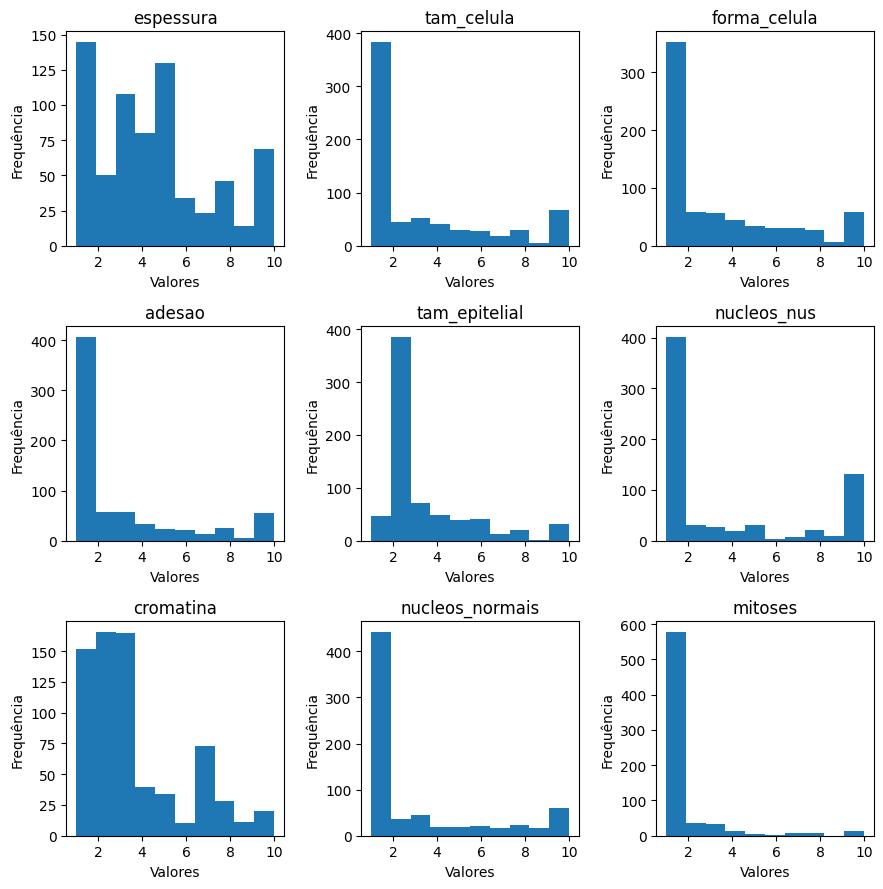

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(9,9), tight_layout=True)
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10)
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')
plt.show()

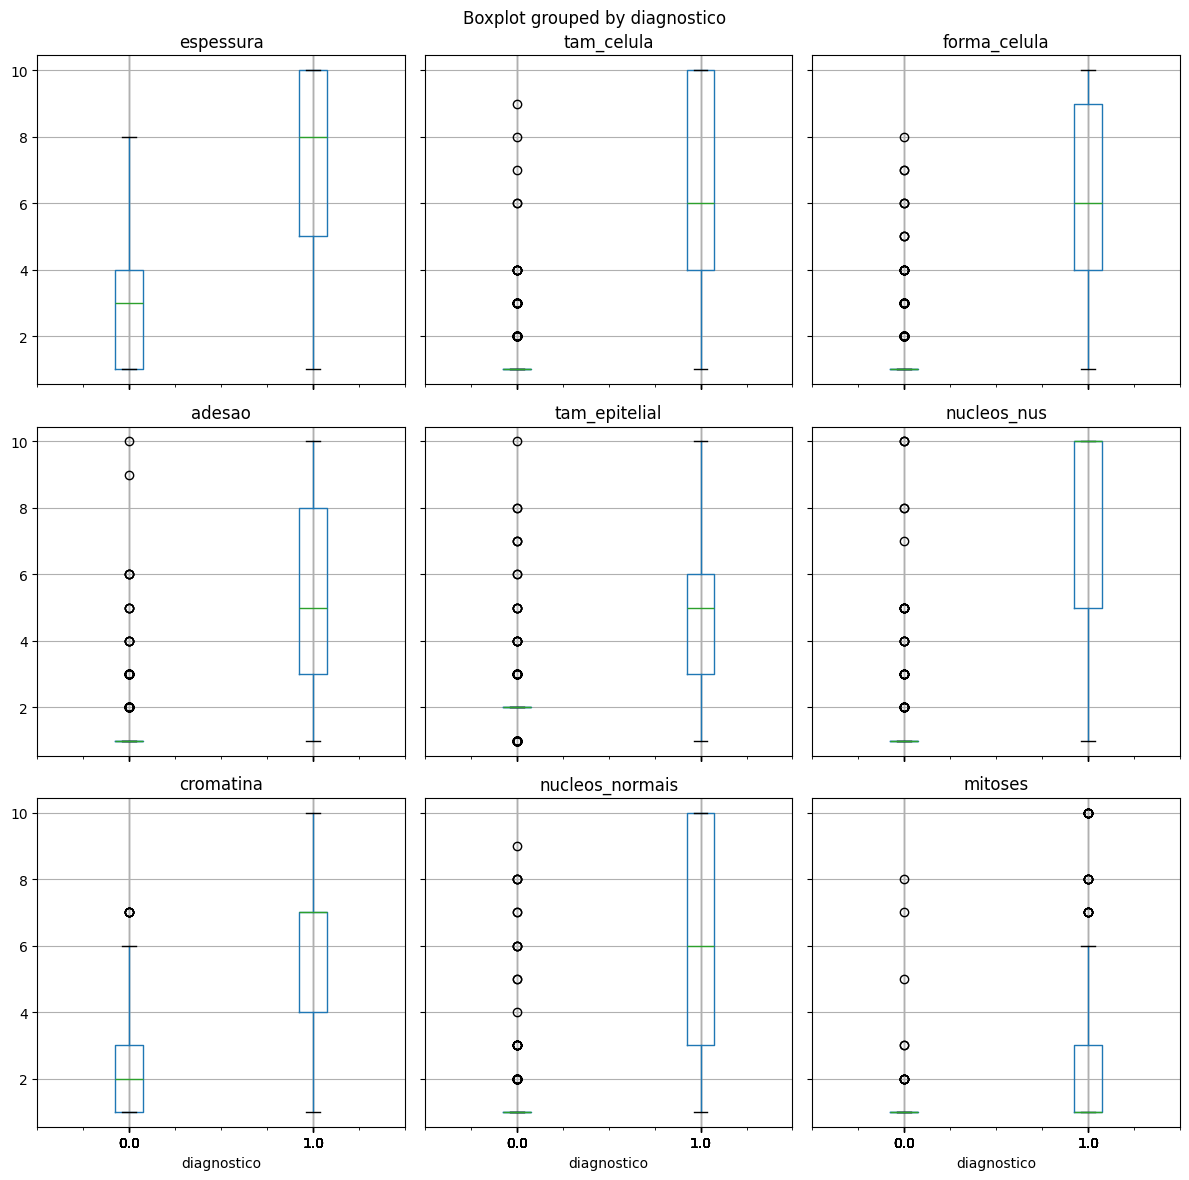

In [28]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12,12))
plt.tight_layout()
plt.show()